In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from model.pconv import PartialConv2d
import torch.nn as nn

In [3]:
input_data = np.load("input_data.npy")
mask_data = np.load("input_mask.npy")

In [4]:
t_in = torch.from_numpy(np.einsum('nijk->nkij', np.expand_dims(input_data,axis=0)))
t_ms = torch.from_numpy(np.einsum('nijk->nkij', np.expand_dims(mask_data,axis=0)))
t_in.shape, t_ms.shape

(torch.Size([1, 3, 778, 1456]), torch.Size([1, 3, 778, 1456]))

In [53]:
# approach1
ngf = 48
one= nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=6, out_channels=ngf, kernel_size=7, padding=0),
            nn.InstanceNorm2d(ngf),
            nn.GELU()
        )

two= nn.Sequential(
            # nn.ReflectionPad2d(3),
            PartialConv2d(in_channels=6, out_channels=ngf, kernel_size=7, multi_channel=True, padding=3),
            nn.InstanceNorm2d(ngf),
            nn.GELU()
        )
pconv = PartialConv2d(in_channels=3, out_channels=ngf, kernel_size=7, multi_channel=True, padding=3)
three = nn.Sequential(
                       nn.InstanceNorm2d(ngf),
                       nn.GELU()
                      )

In [69]:
t_in.shape, t_ms.shape

(torch.Size([1, 3, 778, 1456]), torch.Size([1, 3, 778, 1456]))

In [70]:
torch.cat([t_in, t_in],dim=0).shape

torch.Size([2, 3, 778, 1456])

In [54]:

two_out = three(pconv(torch.cat([t_in, t_in],dim=0), torch.cat([t_ms, t_ms],dim=0)))
two_out[0].shape

torch.Size([48, 778, 1456])

In [68]:
pconv(t_in, t_ms).shape

torch.Size([1, 48, 778, 1456])

In [15]:
feature = torch.cat([t_in, t_ms], dim=1)
one_out = one(feature)

In [85]:
two_out = two(feature)

In [59]:
one_out[0].shape

torch.Size([48, 778, 1456])

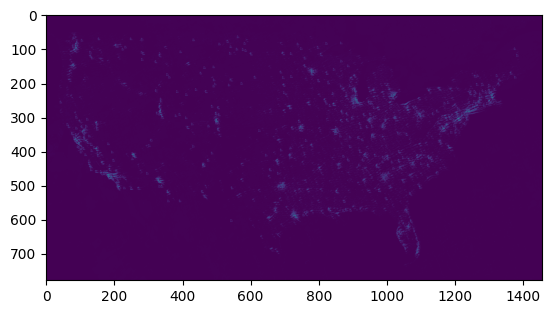

In [64]:
plt.imshow(one_out[0][47].detach().numpy())

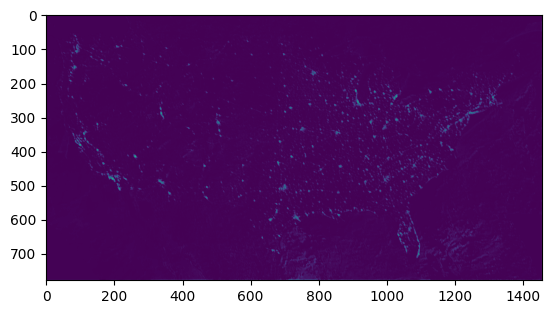

In [66]:
plt.imshow(two_out[0][47].detach().numpy())

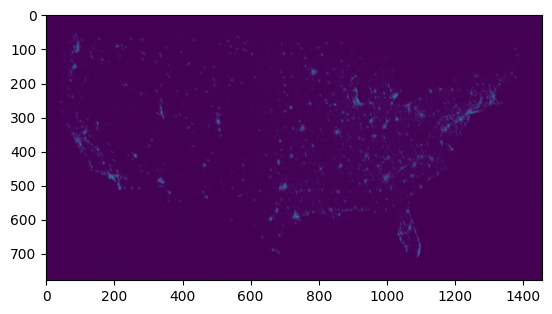

In [34]:
plt.imshow(one_out[0][0].detach().numpy())

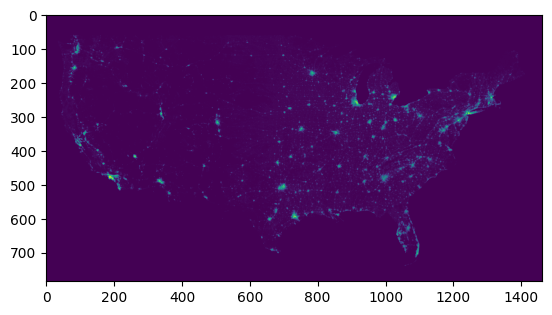

In [48]:
plt.imshow(r_out[0,2,:,:])

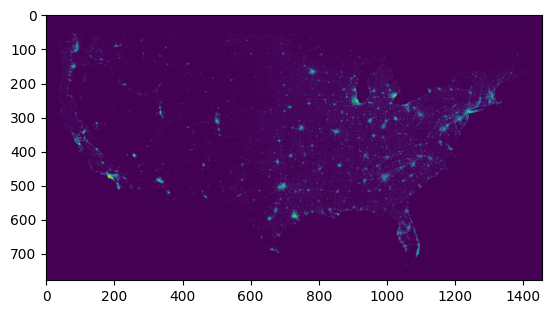

In [50]:
plt.imshow(t_in[0,2,:,:])

In [14]:
import scipy.io as io

In [15]:
out = io.loadmat('/tng4/users/skayasth/Yearly/2023/June/TCEQ_Final/Phase1/runs/May_300/outputs/PCNN_Output_2018.mat')

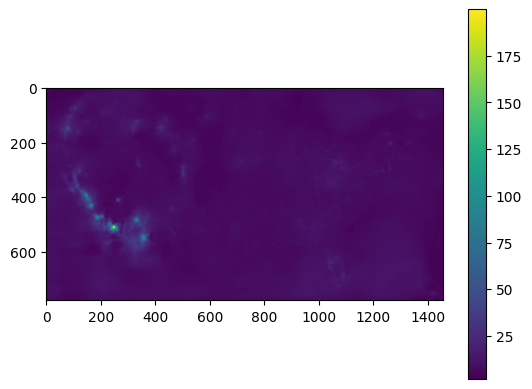

In [21]:
import matplotlib.pyplot as plt
plt.imshow(out['Station_Output'][0])
plt.colorbar()

In [24]:
out['Station_Output'][0].shape

(778, 1456)

In [3]:
padded_height, padded_width = 1024, 1536


# Get the original array shape
original_height, original_width, original_channels = input_data.shape

# Calculate the required amount of padding
pad_height = padded_height - original_height
pad_width = padded_width - original_width

# Calculate the padding sizes for each dimension
top_padding = pad_height // 2
bottom_padding = pad_height - top_padding
left_padding = pad_width // 2
right_padding = pad_width - left_padding


# Perform the zero-padding
day_in_padded = np.pad(input_data, ((top_padding, bottom_padding), (left_padding, right_padding), (0, 0)), mode='constant')
mask_in_padded = np.pad(input_mask, ((top_padding, bottom_padding), (left_padding, right_padding), (0, 0)), mode='constant')


# unpadded_array = padded_array[top_padding:top_padding+original_height, left_padding:left_padding+original_width, :]


# Expand the dimensions to make it compatible with the model
i, j = np.expand_dims(day_in_padded, axis=0), np.expand_dims(
    mask_in_padded, axis=0)

In [4]:
i.shape

(1, 1024, 1536, 512)

In [5]:
import h5py

In [6]:
with h5py.File('data_2018.h5', 'r') as file:
    # Access the group containing your data
    group = file['data']
    loaded_data = {}

    # Load each dataset within the group
    for key in group.keys():
        loaded_data[key] = group[key][()]

In [7]:
def forward(i,j):
    return i[:,:1,:,:]

In [8]:
Station_Output = {}
input_data_all = loaded_data['data']
input_mask_all = loaded_data['mask']

output_daily = np.zeros(
    (input_data_all.shape[0], input_data_all.shape[1], input_data_all.shape[2]))

# Loop through each day
# Phases 1 . Predicting the output for each day with all the stations
for day, (input_data, input_mask) in enumerate(zip(input_data_all, input_mask_all)):
    np.save('input_data.npy', input_data)
    np.save('input_mask.npy', input_mask)
    break
    padded_height, padded_width = 1024, 1536


    # Get the original array shape
    original_height, original_width, original_channels= input_data.shape

    # Calculate the required amount of padding
    pad_height = padded_height - original_height
    pad_width = padded_width - original_width

    # Calculate the padding sizes for each dimension
    top_padding = pad_height // 2
    bottom_padding = pad_height - top_padding
    left_padding = pad_width // 2
    right_padding = pad_width - left_padding


    # Perform the zero-padding
    day_in_padded = np.pad(input_data, ((top_padding, bottom_padding), (left_padding, right_padding), (0, 0)), mode='constant')
    mask_in_padded = np.pad(input_mask, ((top_padding, bottom_padding), (left_padding, right_padding),(0, 0)), mode='constant')
    

    # unpadded_array = padded_array[top_padding:top_padding+original_height, left_padding:left_padding+original_width, :]


    # Expand the dimensions to make it compatible with the model
    i, j = np.expand_dims(day_in_padded, axis=0), np.expand_dims(
        mask_in_padded, axis=0)
    i, j = np.einsum('nijk->nkij', i), np.einsum('nijk->nkij',j)
    daily_out = forward(i, j) #* 450.
    output_daily[day, :, :] = daily_out[0,0,top_padding:top_padding+original_height, left_padding:left_padding+original_width]
    
    one_indices_mask = np.where(input_mask[:, :, 0] == 1)
    index_pairs_mask = np.column_stack(one_indices_mask)
    output_station = np.zeros(
        (len(index_pairs_mask), input_data_all.shape[1], input_data_all.shape[2]))
    print(
        f'Imputing year: {2018}, day: {day}, with {len(index_pairs_mask)} stations')
    
    for n, ip in enumerate(index_pairs_mask):

        # Change mask to 0 for the station (ie impute the station)
        input_mask[ip[0], ip[1], 0] = 0
        input_data[ip[0], ip[1], 0] = 0

        # Pad data and mask to make input size 896x1536
        
        mask_in_padded[59:837, 40:1496, :] = input_mask
        day_in_padded = np.pad(input_data, ((top_padding, bottom_padding), (left_padding, right_padding), (0, 0)), mode='constant')
        mask_in_padded = np.pad(input_mask, ((top_padding, bottom_padding), (left_padding, right_padding),(0, 0)), mode='constant')
    

        # Expand the dimensions to make it compatible with the model
        i, j = np.expand_dims(day_in_padded, axis=0), np.expand_dims(
            mask_in_padded, axis=0)
        i, j = np.einsum('nijk->nkij', i), np.einsum('ijkl->iklj',j)
        station_out = forward(i, j) * 450.
        output_p2 = station_out[0,0,top_padding:top_padding+original_height, left_padding:left_padding+original_width]

        output_daily[day, ip[0], ip[1]
                        ] = output_p2[ip[0], ip[1]]
    
    
    Station_Output['2018'] = output_daily

In [9]:
output_p2.shape

NameError: name 'output_p2' is not defined

In [ ]:
daily_out[0,0,top_padding:top_padding+original_height, left_padding:left_padding+original_width].shape

(778, 1456)

In [ ]:
output_daily.shape

(365, 1456, 3)

In [1]:
import h5py
import dask.array as da
from dask.distributed import Client, LocalCluster

# Set up a local cluster with multiple workers
cluster = LocalCluster(n_workers=12)
client = Client(cluster)

# Open the HDF5 file
with h5py.File('train_data.h5', 'r') as file:
    # Access the group containing the datasets
    group = file['data']

    # Load the datasets into dask arrays in parallel
    dask_arrays = {}
    for key in group.keys():
        dask_arrays[key] = da.from_array(group[key], chunks='auto')

    # Trigger computation and obtain the NumPy arrays
    numpy_arrays = da.compute(*dask_arrays.values())

# Retrieve the NumPy arrays from the output
numpy_arrays = list(numpy_arrays)

# Close the Dask client and cluster
client.close()
cluster.close()


In [4]:
numpy_arrays[0].shape,numpy_arrays[1]

((8000, 512, 512, 3), (8000, 512, 512, 3))

In [22]:
with HDF5DataLoader(file_path, dataset_name, batch_size) as loader:
    for i, data in enumerate(loader):
        print(i)
        # if i==10:
           
        #     break

0 {'train_data': tensor([[[[1.7410e-02, 7.7319e-02, 1.1265e-02],
          [1.7407e-02, 7.7129e-02, 2.7497e-02],
          [1.7392e-02, 7.7152e-02, 2.7606e-02],
          ...,
          [1.2849e-02, 8.2393e-02, 3.3382e-02],
          [1.1975e-02, 8.3592e-02, 2.3604e-02],
          [1.1351e-02, 8.3160e-02, 1.9125e-02]],

         [[1.7236e-02, 7.4281e-02, 1.2171e-02],
          [1.7238e-02, 7.7005e-02, 1.4386e-02],
          [1.7235e-02, 7.5588e-02, 1.3131e-02],
          ...,
          [1.2346e-02, 8.0435e-02, 2.5598e-02],
          [1.1612e-02, 8.0779e-02, 2.2290e-02],
          [1.1061e-02, 8.1727e-02, 1.9314e-02]],

         [[1.7048e-02, 5.8064e-02, 1.3604e-02],
          [1.7061e-02, 6.9744e-02, 1.4676e-02],
          [1.7068e-02, 7.2907e-02, 1.4334e-02],
          ...,
          [1.2036e-02, 7.1847e-02, 2.0321e-02],
          [1.1385e-02, 7.1513e-02, 1.9939e-02],
          [1.0878e-02, 7.3823e-02, 2.4585e-02]],

         ...,

         [[4.4612e-02, 5.3469e-02, 0.0000e+00],
     

KeyboardInterrupt: 